In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [11]:
# 1. no biopsy, no treatment
S = np.random.gamma(shape=1, scale=3/2, size=100000)
Y = np.where(S > 9999999, S, 0)
BR = np.random.normal(loc=S, scale = np.sqrt( (S**2 + 4) / 4 ))


Uy = (1-np.exp(-Y))/(1-np.exp(-6))

X = (110000 - 0) / 110000
Ux = (1-np.exp(-X))/(1-np.exp(-1))

U = 0.2 * Ux + 0.7 * Uy + 0.1 * Ux * Uy
print(U.mean())

0.20000000000000004


In [12]:
# 2. no biopsy, treatment
S = np.random.gamma(shape=1, scale=3/2, size=100000)
Y = np.where(S > 3, S, 0)
BR = np.random.normal(loc=S, scale = np.sqrt( (S**2 + 4) / 4 ))


Uy = (1-np.exp(-Y))/(1-np.exp(-6))

X = (110000 - 100000) / 110000
Ux = (1-np.exp(-X))/(1-np.exp(-1))

U = 0.2 * Ux + 0.7 * Uy + 0.1 * Ux * Uy
print(U.mean())

0.12203061781726783


In [13]:
# 3. biopsy, no treatment
S = np.random.gamma(shape=1, scale=3/2, size=100000)
BR = np.random.normal(loc=S, scale = np.sqrt( (S**2 + 4) / 4 ))
Y = np.where(S > 9999999, S, 0)

Uy = (1-np.exp(-Y))/(1-np.exp(-6))

X = (110000 - 10000) / 110000
Ux = (1-np.exp(-X))/(1-np.exp(-1))

U = 0.2 * Ux + 0.7 * Uy + 0.1 * Ux * Uy
print(U.mean())

0.18892272055742895


In [29]:
# 4. biopsy, some treatment, but we are not given the BR val that tells us to do the treatment


current_biopsy_threshold = 3.2
u_mean = []
while True:
    S = np.random.gamma(shape=1, scale=3/2, size=1000000)
    BR = np.random.normal(loc=S, scale = np.sqrt( (S**2 + 4) / 4 ))
    U = []
    for i in range(len(S)):
        if BR[i] > current_biopsy_threshold:
            # do the treatment
            Y = S[i] if S[i] > 3 else 0
            X = (110000 - 110000) / 110000
        else:
            # don't do the treatment
            Y = 0
            X = (110000 - 10000) / 110000
    
        Uy = (1-np.exp(-Y))/(1-np.exp(-6))
        Ux = (1-np.exp(-X))/(1-np.exp(-1))
        U.append(0.2 * Ux + 0.7 * Uy + 0.1 * Ux * Uy)  
    u_mean.append(np.mean(U))
    print(current_biopsy_threshold, np.mean(U))
    current_biopsy_threshold += 0.02
    if current_biopsy_threshold > 3.7:
        break

3.2 0.22109724654648477
3.22 0.220916827686534
3.24 0.22105807657281
3.2600000000000002 0.22120146380119787
3.2800000000000002 0.221153934320042
3.3000000000000003 0.22111887846847655
3.3200000000000003 0.22124819040058313
3.3400000000000003 0.22120488624001672
3.3600000000000003 0.2213826270542266
3.3800000000000003 0.22128308379257808
3.4000000000000004 0.22128981822691077
3.4200000000000004 0.2210701802159959
3.4400000000000004 0.2212081213671178
3.4600000000000004 0.22110842859412427
3.4800000000000004 0.2212105017482116
3.5000000000000004 0.22108241798953981
3.5200000000000005 0.2212168957104271
3.5400000000000005 0.22091571663646273
3.5600000000000005 0.22125474587367627
3.5800000000000005 0.22090866059044892
3.6000000000000005 0.2208885956632518
3.6200000000000006 0.22096618019346023
3.6400000000000006 0.2208001279965762
3.6600000000000006 0.22096131525488702
3.6800000000000006 0.22074362833453431


In [30]:
max_index = np.argmax(u_mean)
print(max_index, u_mean[max_index])

8 0.2213826270542266


In [31]:
print(max_index * 0.02 + 3.2)

3.3600000000000003


In [55]:
model = pm.Model()

with model:

    S = pm.Gamma("S", alpha=1, beta=2/3)  #alpha=shape, beta = rate = 1/scale
    
    BR = pm.Normal("BR", mu=S, tau=4 / (S ** 2 + 4), observed=3.5)
    # Since the observed is 3.5, we will do the treatment
    
    Y = pm.Deterministic("Y", pm.math.where(S > 3, S, 0))
    # Y = pm.math.where(S > 3, S, 0)
    X = 0
    
    Uy = pm.Deterministic('Uy', (1 - pm.math.exp(-Y)) / (1 - np.exp(-6)))
    Ux = pm.Deterministic('Ux', (1 - pm.math.exp(-X)) / (1 - np.exp(-1)))

    
    U = pm.Deterministic("U", 0.2 * Ux + 0.7 * Uy + 0.1 * Ux * Uy)

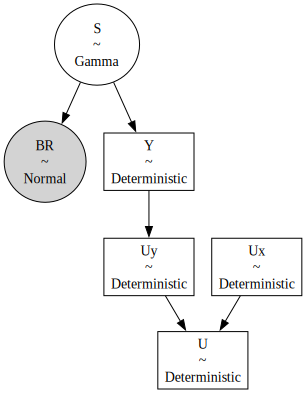

In [56]:
pm.model_to_graphviz(model)

In [61]:
with model:
    trace = pm.sample(draws=10000,tune=1000,chains=4, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [S]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.


C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
S,2.585,1.225,0.621,4.934,0.010,0.007,12867.0,13169.0,1.0
Y,1.207,1.938,0.000,4.648,0.014,0.010,18593.0,18219.0,1.0
Uy,0.292,0.448,0.000,0.993,0.003,0.002,18593.0,18219.0,1.0
Ux,0.000,0.000,0.000,0.000,0.000,0.000,40000.0,40000.0,NaN
U,0.204,0.313,0.000,0.695,0.002,0.002,18593.0,18219.0,1.0


C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


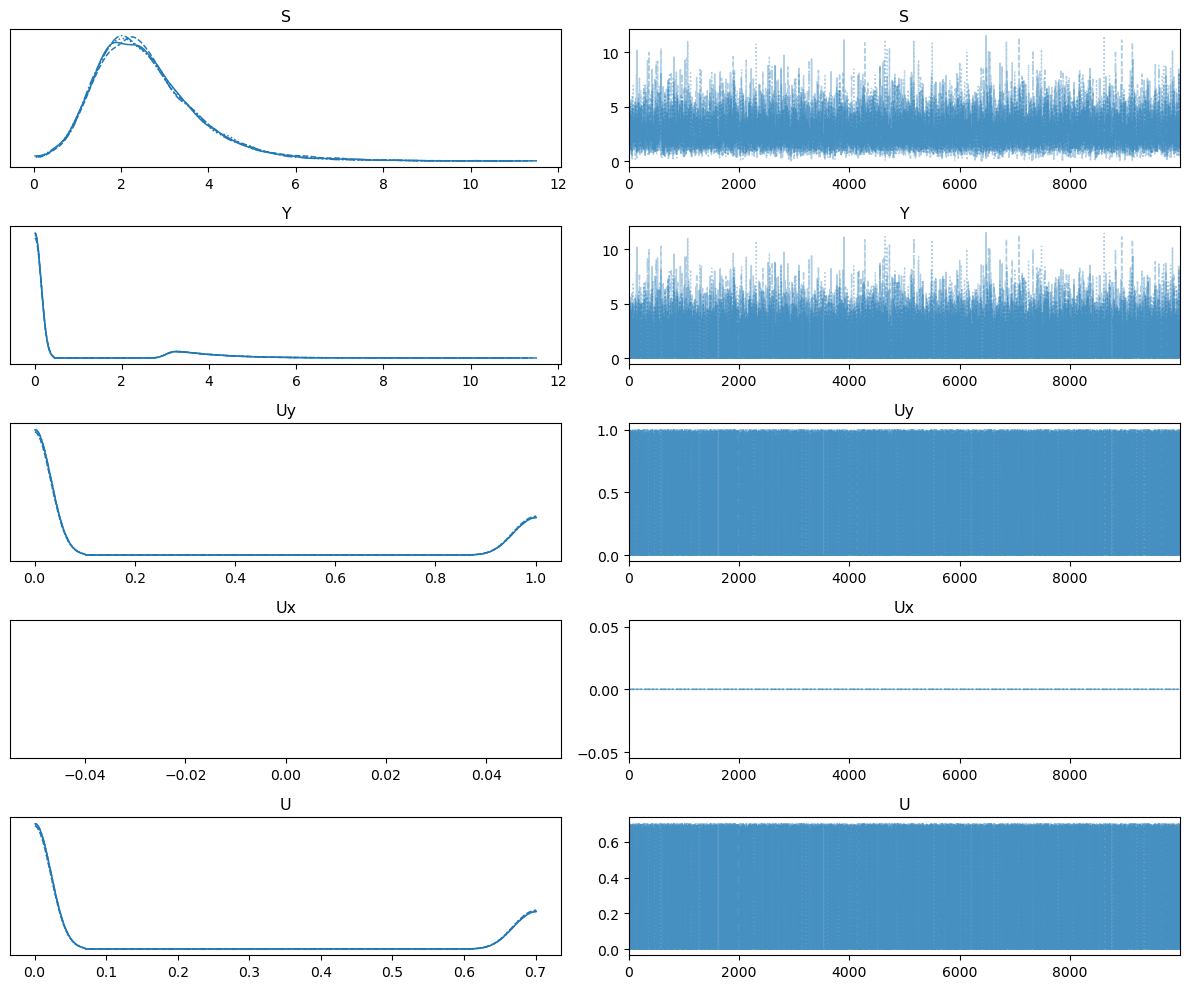

In [62]:
with model:
    display(az.summary(trace))
    az.plot_trace(trace)
    plt.tight_layout()

In [64]:
# extract the posterior of Y
Y = trace["posterior"]["Y"].to_numpy()
X = np.zeros(Y.shape)

Uy = (1-np.exp(-Y))/(1-np.exp(-6))
Ux = (1-np.exp(-X))/(1-np.exp(-1))

U = 0.2 * Ux + 0.7 * Uy + 0.1 * Ux * Uy

print(U.mean())

0.2042536540465418


In [63]:
(trace['posterior']['U']).to_numpy().mean()

0.2042536540465418